# Singoli Continenti

Dati dei singoli continenti.

> Max Pierini

***

Legenda:

- Cumulativi
    - Rosso: deceduti
    - Verde: guariti
    - Blu: positivi

- $R_t$
    - Rosso: maggiore di 1
    - Verde: minore di 1

- metodo EpiEstim implementato in `python` (vedi [Stima Rt e previsioni](https://www.epidata.it/Italia/stime_Rt.html))

> NB: gli $R_t$ stimati da EpiDataItalia sono parametrizzati attualmente sui <u>soli nuovi casi</u> e **non sono sovrapponibili al numero di riproduzione stimato da ISS-EpiCentro** che utilizza lo stesso modello *EpiEstim* ([A new framework and software to estimate time-varying reproduction numbers during epidemics, Cori-Ferguson-Fraser 2013](https://doi.org/10.1093/aje/kwt133)) ma con dati aggiuntivi attualmente **non disponibili al pubblico** (il numero di casi sintomatici con data di inizio sintomi, il numero di casi sintomatici importati da un’altra regione o dall’estero). Per info sul modello in uso da ISS-EpiCentro consultare la pagina [FAQ sul calcolo del Rt](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt) di ISS. Per chiedere al Governo l'accesso pubblico a tutti i dati grezzi disaggregati di COVID-19 in Italia consigliamo l'adesione alla **[Petizione DatiBeneComune](https://datibenecomune.it)**.

In [1]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Markdown, display, Math
import pandas as pd
import scipy.stats as sps
import seaborn as sns
sns.set()

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
start = dt.datetime.now()

In [3]:
SI_sh_ISS = 1.87
SI_ra_ISS = 0.28

def gamma_mu_sd_from_shape_rate(shape, rate):
    mu = shape / rate
    sd = np.sqrt(shape) / rate
    return mu, sd

def overall_infectivity(incid, SI_y):
    T = incid.size
    _lambda = np.zeros(T)
    _lambda[0] = np.nan
    for t in range(T):
        if not t:
            continue
        _lambda[t] = np.sum(
            SI_y[:t+1] * 
            incid[:t+1][::-1]
        )
    return _lambda

def posterior_from_si_distr(incid, SI_y, a_prior, b_prior, t_start, t_end):
    nb_time_periods = t_start.size
    _lambda = overall_infectivity(incid, SI_y)
    final_mean_si = np.sum(
        SI_y * np.arange(0, SI_y.size, 1)
    )
    a_posterior = np.zeros(shape=nb_time_periods)
    b_posterior = np.zeros(shape=nb_time_periods)
    for t in range(nb_time_periods):
        incid_sum = np.sum(incid[t_start[t]:t_end[t]+1])
        lambda_sum = np.sum(_lambda[t_start[t]:t_end[t]+1])
        if t_end[t] > final_mean_si and incid_sum > 25:
            a_posterior[t] = a_prior + incid_sum
            b_posterior[t] = 1 / (1 / b_prior + lambda_sum)
        else:
            a_posterior[t] = .01
            b_posterior[t] = 1
    return a_posterior, b_posterior, lambda_sum

def epi_estim_Rt(df,
                 SI_mu=None, SI_sd=None,
                 SI_sh=None, SI_ra=None,
                 mu_prior=5, sd_prior=5,
                 CI=.99,
                 plot_incidence=False,
                 plot_Rt=True,
                 ax=None,
                 plot_SI=False,
                 plot_infectivity=False,
                 title='RESULTS',
                 window=14):
    
    cond1 = SI_mu is None and SI_sd is None
    cond2 = SI_sh is None and SI_ra is None
    
    if cond1 and cond2:
        raise Exception('Either SI_mu, SI_sd or SI_sh, SI_ra must be provided.')
    
    df = df.copy(deep=True)
    
    df.columns = ['incidence']
    incid = df.values.ravel()
    idx = df.index
    
    if plot_incidence:
        ax = df.plot(lw=1, color='k', alpha=.75, figsize=(12, 4))
        zero_incidence = df[df==0]
        if zero_incidence.size:
            ax.plot(zero_incidence, marker='o', ls='none', color='b', label='zero new cases')
        less_incidence = df[df<0]
        if less_incidence.size:
            ax.plot(less_incidence, marker='s', ls='none', color='r',label='less than zero')
        ax.legend()
        ax.set(
            title=f'{title} observed incidence'
        )
        plt.show()
    
    less_than_zero = incid < 0
    if less_than_zero.sum():
        print('WARNING: negative values in incidence. Forcing to NaN. Values will be imputed.')
        df.loc[df.incidence<0, 'incidence'] = np.nan
    
    nans = np.isnan(incid).sum()
    if nans:
        print('WARNING: NaN values in incidence. Imputing values with ffill method...')
        df.fillna(method='ffill', inplace=True)
        incid = df.values.ravel()
    
    # quantiles for confidence window
    q1 = (1 - CI) / 2
    q2 = 1 - q1
    
    if SI_mu is None:
        SI_mu, SI_sd = gamma_mu_sd_from_shape_rate(SI_sh, SI_ra)
    
    # calculate discretized serial window distribution
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x_min = 0
    SI_x_max = int(SI_dist.ppf(.999))
    SI_mu = SI_dist.stats(moments='m')
    SI_x = np.linspace(SI_x_min, SI_x_max, SI_x_max+1)
    SI_y = SI_dist.pdf(SI_x)
    # pad SI with zeros
    SI_tot = np.concatenate((SI_y, np.zeros(incid.size - SI_y.size)))
    
    if plot_SI:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(SI_x, SI_y, alpha=.5)
        ax.axvline(SI_mu, color='r', ls='--')
        ax.set(
            title=f'{title} Serial Interval: $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$, '+\
                  f'shape={SI_sh:.3f}, rate={SI_ra:.3f}'
        )
        plt.show()
    
    # calculate shape and scale Rt priors
    a_prior = (mu_prior / sd_prior) ** 2
    b_prior = (sd_prior ** 2) / mu_prior
    
    # length of all observations
    T = incid.size
    
    # start and end of posteriors
    t_start = np.arange(1, T - (window - 1), 1)
    t_end = t_start + (window - 1)
    
    # calculate a and b posteriors
    a_posterior, b_posterior, lambda_sum = posterior_from_si_distr(
        incid, SI_tot, a_prior, b_prior, t_start, t_end)

    # mean of Rt posteriors
    mean_posterior = a_posterior * b_posterior

    # standard deviation of Rt posteriors
    std_posterior = np.sqrt(a_posterior) * b_posterior

    # lower quantile of Rt posterior
    quantile_lo_posterior = sps.gamma.ppf(q1,
      a=a_posterior,
      scale=b_posterior
    )
    # higher quantile of Rt posterior
    quantile_hi_posterior = sps.gamma.ppf(q2,
      a=a_posterior,
      scale=b_posterior
    )
    
    res_index = idx[:-window]
    res = pd.DataFrame({
        'date': res_index,
        'R': mean_posterior,
        'std': std_posterior,
        f'q_{q1:.2%}': quantile_lo_posterior,
        f'q_{q2:.2%}': quantile_hi_posterior,
    })
    res.set_index('date', inplace=True)
    
    if plot_Rt:    
        res.plot(
            y='R', color='w', alpha=.1, lw=1, ylim=(0, 5),
            ax=ax
        )

        ax.fill_between(
            res.index, 
            np.where(quantile_hi_posterior<1, quantile_hi_posterior, 1), 
            np.where(quantile_lo_posterior<1, quantile_lo_posterior, 1), 
            alpha=1, color='C2', label='lower than 1')

        ax.fill_between(
            res.index, 
            np.where(quantile_hi_posterior>1, quantile_hi_posterior, 1), 
            np.where(quantile_lo_posterior>1, quantile_lo_posterior, 1), 
            alpha=1, color='C3', label='higher than 1')

        ax.set(
            title=f'{title}: Rt (C.I. {CI:.0%})',
            ylim=(0, 5),
            xlim=(idx[0], idx[-1]),
            ylabel='Rt'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        #ax.legend(False)

        ax.axhline(1, color='k', ls='-', alpha=.5)
        #plt.show()
    
    return res

In [4]:
CONTINENTS = {
    'Europe' : [
        [-31.640625000000004, 65.22621580443068],
        [-14.414062500000002, 34.61488236933614],
        [6.679687500000001, 38.072307761177434],
        [11.370849609375002, 37.16119853011621],
        [17.797851562500004, 33.397115779277804],
        [28.125000000000004, 34.59920735944525],
        [25.8837890625, 39.67474804022493],
        [46.8017578125, 47.18873069925806],
        [49.39453125000001, 68.71633004347179],
        [33.31054687500001, 71.38259358177613],
        [34.80468750000001, 81.30764752063995],
        [2.2851562500000004, 81.03795908502426],
        [-9.492187500000002, 71.68874457897826],
        [-31.640625000000004, 65.22621580443068]
    ],

    'North America' : [
        [-169.1015625, 64.62821321164643],
        [-166.28906250000003, -4.543542325116384],
        [-78.13476562500001, 6.756667073863536],
        [-71.36718750000001, 13.756477901798519],
        [-64.16015625000001, 17.7309196625975],
        [-44.82421875000001, 57.420532112950106],
        [-14.589843750000002, 70.49376030888776],
        [-7.031250000000001, 82.89536246413655],
        [-55.89843750000001, 84.47261624784551],
        [-169.1015625, 76.30842959767809],
        [-169.1015625, 64.62821321164643]
    ],

    'South America' : [
        [-77.56347656250001, 8.279379638294253],
        [-64.68750000000001, 21.576517441880682],
        [-29.443359375000004, -4.120792478444098],
        [-24.609375000000004, -60.4493040040189],
        [-88.06640625000001, -62.947608688260644],
        [-94.833984375, 2.8207588757032247],
        [-87.67089843750001, 6.53512652521894],
        [-79.6728515625, 5.355161897343376],
        [-77.56347656250001, 8.279379638294253]
    ],

    'Africa' : [
        [-5.822753906250001, 35.8982639097007],
        [-27.773437500000004, 21.622900762503807],
        [-25.400390625, 9.284004953723443],
        [17.050781250000004, -40.36817383631919],
        [52.82226562500001, -37.07827065362777],
        [65.56640625000001, -7.003095280765394],
        [50.80078125, 12.648184681156543],
        [43.76953125, 11.703272060234015],
        [33.31054687500001, 32.625219206745705],
        [13.095703125, 34.74557902553385],
        [10.371093750000002, 38.135341501071856],
        [-5.822753906250001, 35.8982639097007]
    ],

    'Asia' : [
        [25.7080078125, 39.67331233790472],
        [46.8017578125, 47.18873069925806],
        [49.39453125000001, 68.71633004347179],
        [41.13281250000001, 81.77294634653771],
        [102.65625000000001, 82.89624647530583],
        [110.56640625000001, 78.83291966348615],
        [171.73828125000003, 71.24040773185591],
        [158.37890625000003, 12.72574473600403],
        [107.22656250000001, -19.96955352290411],
        [70.48828125000001, -2.4585117809536152],
        [51.06445312500001, 13.281595272644003],
        [43.68164062500001, 11.952395812630918],
        [33.44238281250001, 31.762296498750874],
        [26.674804687500004, 36.3114692228268],
        [25.7080078125, 39.67331233790472]
    ],

    'Oceania' : [
        [140.53710937500003, -0.17409843920933274],
        [125.33203125000001, -11.261516780469037],
        [109.24804687500001, -21.612318151487756],
        [110.91796875000001, -40.03402568388044],
        [168.39843750000003, -53.842915608904335],
        [179.73632812500003, -37.99056612188769],
        [179.89013671875003, -19.662061845069733],
        [179.9560546875, -14.92293771873999],
        [174.72656250000003, -11.169272081768627],
        [140.53710937500003, -0.17409843920933274]
    ]   
}

In [5]:
def point_in_continent(lats, lngs, continents):
    results = []
    for lat, lng in zip(lats, lngs):
        point = Point([float(lng), float(lat)])
        continent_name = np.nan
        for continent in continents:
            poly = continents[continent]
            polygon = Polygon(poly)
            if polygon.contains(point):
                continent_name = continent
                break
        results.append(continent_name)

    return results

In [6]:
T = pd.read_csv(
    "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
    #index_col=["Country/Region", 'Lat', 'Long']
).sort_index()
R = pd.read_csv(
    "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv",
    #index_col=["Country/Region"]
).sort_index()
D = pd.read_csv(
    "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv",
    #index_col=["Country/Region"]
).sort_index()

In [7]:
T['Continent'] = point_in_continent(
    T.Lat, T.Long, CONTINENTS
)

T_con = T.drop([
    'Province/State', 'Country/Region', 'Lat', 'Long',
], axis=1).groupby('Continent').sum().T

T_con.index = pd.to_datetime(T_con.index)

R['Continent'] = point_in_continent(
    R.Lat, R.Long, CONTINENTS
)

R_con = R.drop([
    'Province/State', 'Country/Region', 'Lat', 'Long',
], axis=1).groupby('Continent').sum().T

R_con.index = pd.to_datetime(R_con.index)

D['Continent'] = point_in_continent(
    D.Lat, D.Long, CONTINENTS
)

D_con = D.drop([
    'Province/State', 'Country/Region', 'Lat', 'Long',
], axis=1).groupby('Continent').sum().T

D_con.index = pd.to_datetime(D_con.index)

In [8]:
P_con = T_con - (D_con + R_con)

# Africa

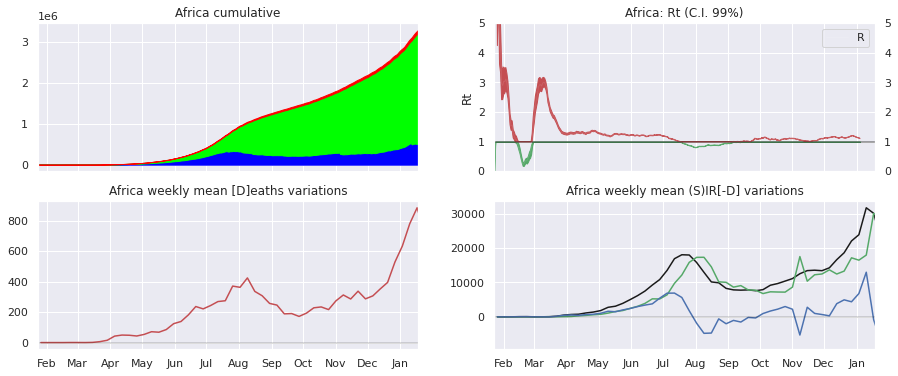

***

# Asia

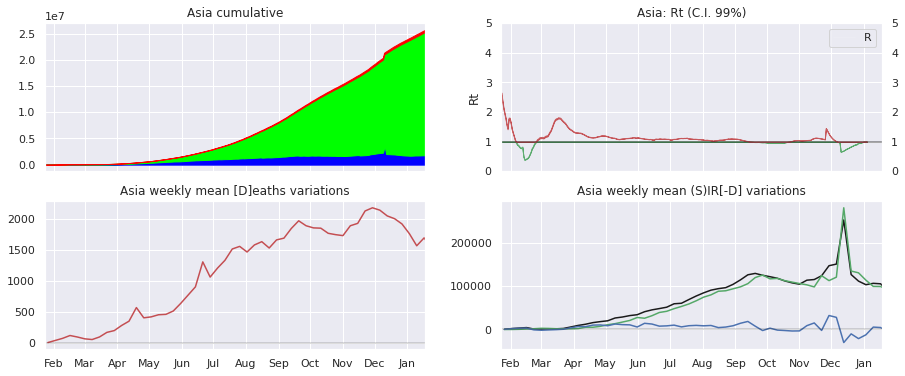

***

# Europe

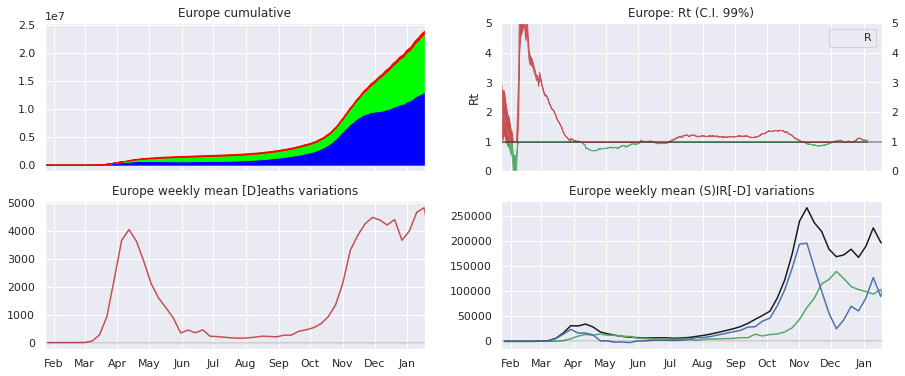

***

# North America

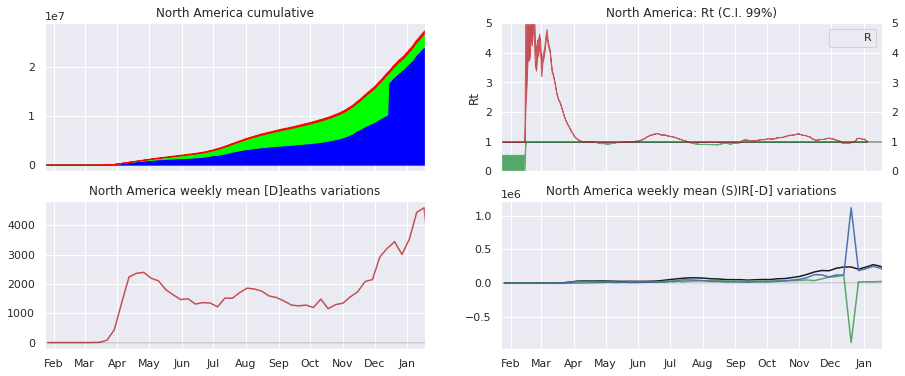

***

# Oceania

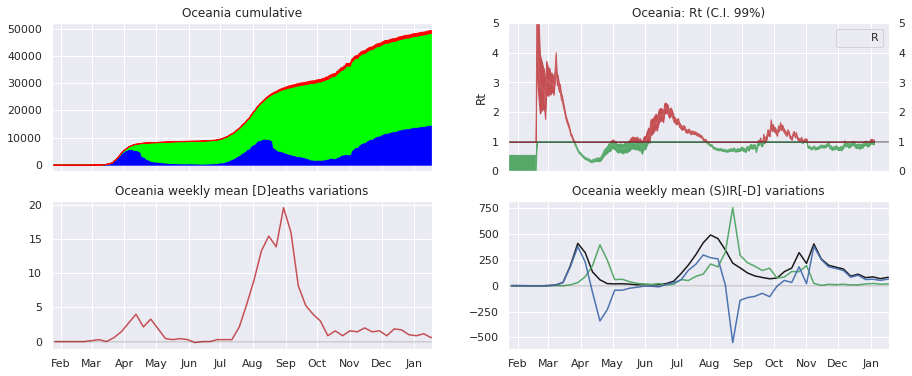

***

# South America

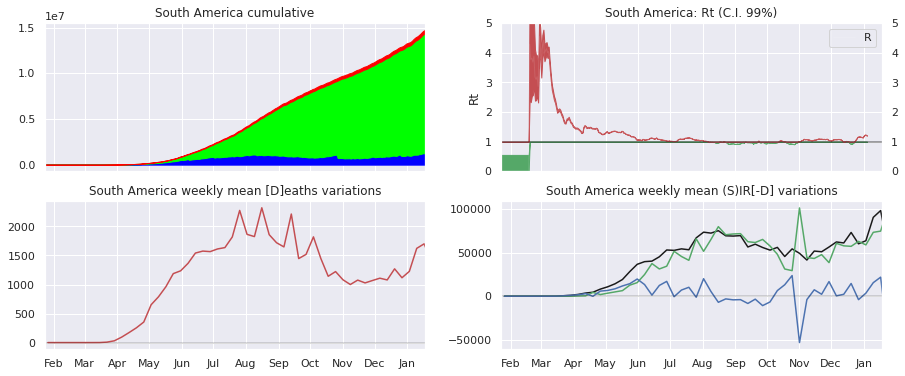

***

In [9]:
for continent in T_con.columns:
    display(Markdown(f"# {continent}"))
    fig, ax = plt.subplots(2, 2, figsize=(15, 6), sharex=True)
    
    t = T_con[continent]
    d = D_con[continent]
    r = R_con[continent]
    p = P_con[continent]
    
    i = T_con.index
    
    lo, hi = 0, p.values
    ax.flat[0].fill_between(i, lo, hi, color='blue')
    lo, hi = hi, hi + r.values
    ax.flat[0].fill_between(i, lo, hi, color='#00ff00')
    lo, hi = hi, hi + d.values
    ax.flat[0].fill_between(i, lo, hi, color='red')
    ax.flat[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.flat[0].xaxis.set_major_locator(mdates.MonthLocator())
    ax.flat[0].set_title(f"{continent} cumulative")

    incidence = t.diff()
    incidence[incidence<0] = 0
    
    _ = epi_estim_Rt(incidence[1:],
                    SI_sh=SI_sh_ISS,
                    SI_ra=SI_ra_ISS,
                    ax=ax.flat[1],
                    title=continent)
    
    ax.flat[3].plot(t.diff().resample('W').mean(), 'k')
    ax.flat[3].plot(r.diff().resample('W').mean(), 'g')
    ax.flat[3].plot(p.diff().resample('W').mean(), 'b')
    ax.flat[3].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.flat[3].xaxis.set_major_locator(mdates.MonthLocator())
    ax.flat[3].axhline(0, c='k', alpha=.2)
    ax.flat[3].set_title(f"{continent} weekly mean (S)IR[-D] variations")

    ax.flat[2].plot(d.diff().resample('W').mean(), 'r')
    ax.flat[2].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.flat[2].xaxis.set_major_locator(mdates.MonthLocator())
    ax.flat[2].axhline(0, c='k', alpha=.2)
    ax.flat[2].set_title(f"{continent} weekly mean [D]eaths variations")
    
    plt.show()
    plt.close(fig='all')
    display(Markdown("***"))

In [10]:
end = dt.datetime.now()
time = end-start
print(f"COMPLETED IN {end-start}")
print(f"{time / T_con.columns.size} per continent.")

COMPLETED IN 0:00:24.434374
0:00:04.072396 per continent.
